In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

### This is example 1 for the paper - a 3 comm SBM

In [79]:
# Network generation --------------------------------------------------------
random.seed(1)

n = 300  # number of nodes
K = 3    # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []
B_list.append(np.array([[0.55, 0.4, 0.4], 
                        [0.4, 0.2, 0.3], 
                        [0.5, 0.3, 0.6]]))

In [80]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [81]:
random.seed(10)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

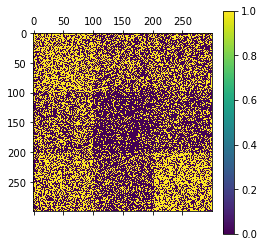

In [82]:
# Sample drawn using the above P in a Bern(P) - this is the Observed A matrix
cax = plt.matshow(As)
plt.colorbar(cax)
plt.show()

In [85]:
ya = UASE([As.astype(float)], 2)
plot_embedding(ya, n, 1, tau)

In [117]:
title="3 Community SBM with n=300 nodes embedded with UASE into d=2 dimensions"
T=1

yadf = pd.DataFrame(ya[:, 0:2])
yadf.columns = ["Dimension {}".format(i + 1) for i in range(yadf.shape[1])]
yadf["Time"] = np.repeat([t for t in range(T)], n)
yadf["Community"] = list(tau) 
yadf["Community"] = yadf["Community"].astype(str)
pad_x = (max(ya[:, 0]) - min(ya[:, 0])) / 50
pad_y = (max(ya[:, 1]) - min(ya[:, 1])) / 50
fig = px.scatter(
    yadf,
    x="Dimension 1",
    y="Dimension 2",
    color="Community",
    animation_frame="Time",
    range_x=[min(ya[:, 0]) - pad_x, max(ya[:, 0]) + pad_x],
    range_y=[min(ya[:, 1]) - pad_y, max(ya[:, 1]) + pad_y])

# fig.update_layout(title=title, title_font_size=14)
fig.update_traces(marker=dict(size=5))  # Adjust the size as desired
fig.update_layout(
    width=600,  # Adjust width as desired
    height=300,  # Adjust height as desired
)

fig.write_image("3_Community_SBM_n300_UASE_d2.png")

fig.show()

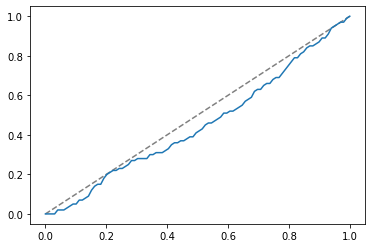

0.02

In [84]:
A_obs = As.astype(float)
p_vals, A_boots = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_boots[0]

plot_power(p_vals, plot=True)

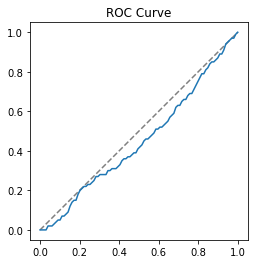

In [114]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc)

# Set title and aspect ratio
plt.title("ROC Curve")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("3_Community_SBM_n300_UASE_d2_curve.png")

plt.show()

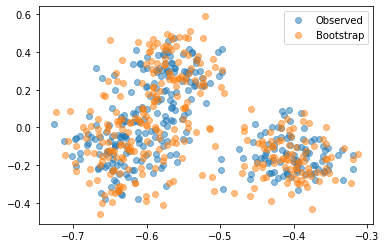

In [68]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.5)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=0.5)

plt.legend()

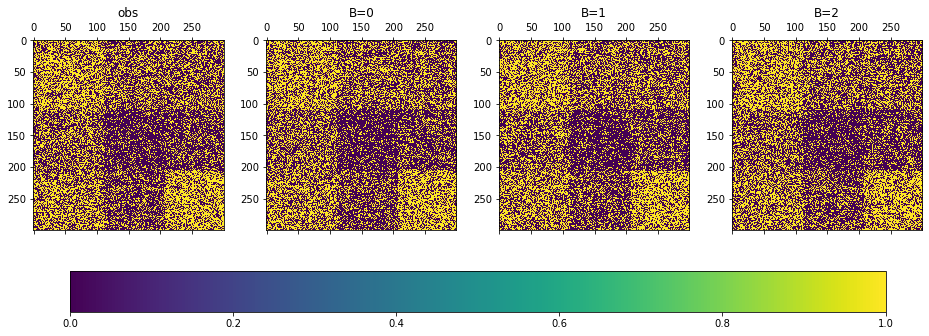

In [69]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

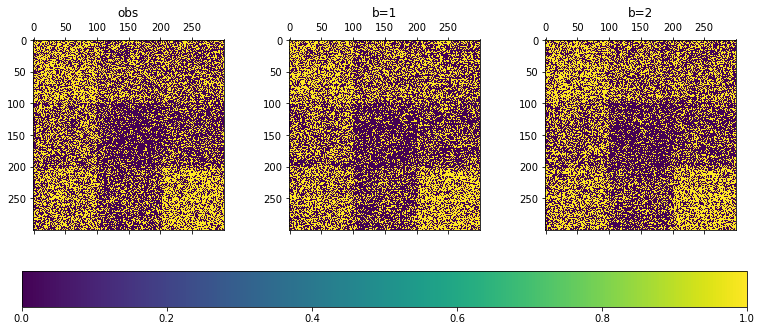

In [122]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(13,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('b=1')
ax1.matshow(A_boots[0])
ax2.set_title('b=2')
ax2.matshow(A_boots[1])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2], orientation='horizontal')

fig.savefig("3_Community_SBM_n300_UASE_d2_heatmaps.png")

Mixed Membership model

In [71]:
# Code up a mixed membership model 
random.seed(1)

K=3
n= 300

# use our new function to make a MMSBM
A, largest_prob, P = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], 2)
plot_embedding(ya, n, 1, largest_prob)

This isn't actually community, it is just the one probabilistically they are most likely to belong to

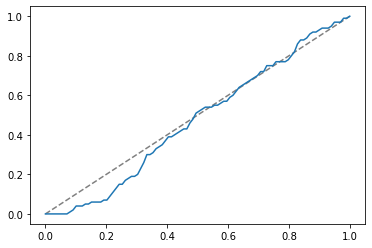

0.0

In [72]:
A_obs = A.copy()
p_vals, A_ests = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_ests[0]

plot_power(p_vals, plot=True)

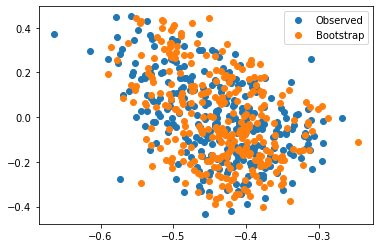

In [73]:
A_res = make_inhomogeneous_rg(P)

yhat_est = UASE([A_obs,A_est, A_res], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.legend()